In [7]:
import proplot as pplt
import numpy as np
from mdet_tools import meas_m, meas_mbmeds, make_obs, format_mc_res

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
n_stars = 20
res = meas_m(n_stars=n_stars, mask_width=2, seed=20, n_jobs=100, sym=3)

print("\nstar density: %s [num per arcmin^2]" % (n_stars / (235*0.20/60)**2))
print(format_mc_res(res))

In [ ]:
n_stars = 20
res = meas_m(n_stars=n_stars, mask_width=2, seed=20, n_jobs=10, sym=False)

print("\nstar density: %s [num per arcmin^2]" % (n_stars / (235*0.20/60)**2))
print(format_mc_res(res))

In [ ]:
n_stars = 20
step = 0.01
s = 10
kwargs = {"n_stars": n_stars, "seed": s}
d, mbobs = meas_mbmeds(make_obs(mcal_shear=(0, 0), **kwargs), mask_width=2, sym=3)
d1p, mbobs1p = meas_mbmeds(make_obs(mcal_shear=(step, 0), **kwargs), mask_width=2, sym=3)
d1m, mbobs1m = meas_mbmeds(make_obs(mcal_shear=(-step, 0), **kwargs), mask_width=2, sym=3)

fig, axs = pplt.subplots(nrows=1, ncols=3, sharex=3, sharey=3)
axs[0].pcolormesh(mbobs[0][0].image)
axs[0].plot(d["x"], d["y"], '.b')
axs[0].set_title("mcal noshear")

axs[1].pcolormesh(mbobs1p[0][0].image)
axs[1].plot(d1p["x"], d1p["y"], '.b')
axs[1].set_title("mcal +g1")

axs[2].pcolormesh(mbobs1m[0][0].image)
axs[2].plot(d1m["x"], d1m["y"], '.b')
axs[2].set_title("mcal -g1")

axs.set_xlim(0, mbobs[0][0].image.shape[1])
axs.set_ylim(0, mbobs[0][0].image.shape[0])

In [8]:
from mdet_tools import meas_response_one_im

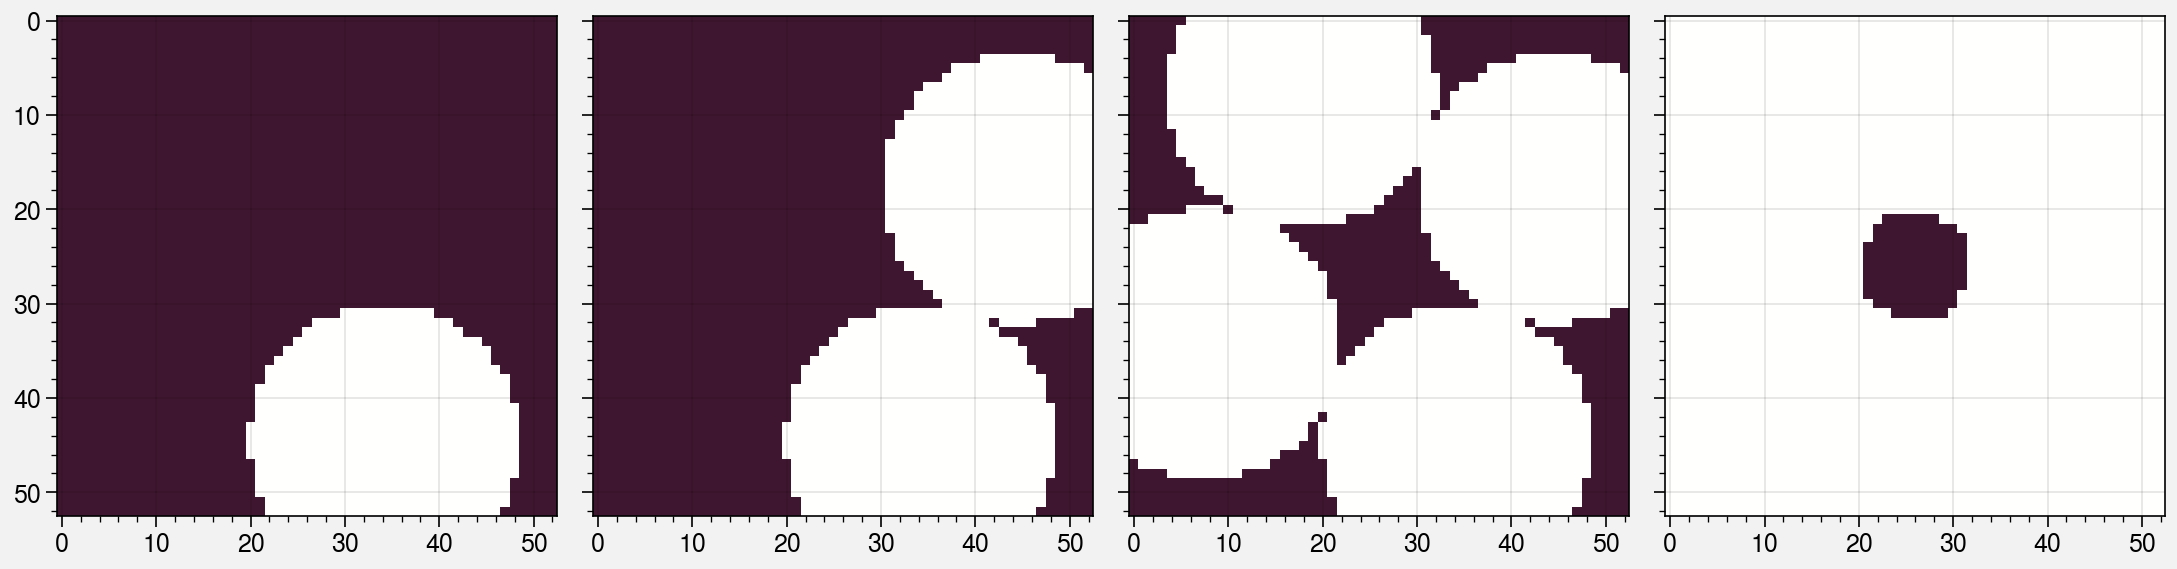

In [20]:
seed = np.random.randint(low=1, high=2**29, size=100)[0]

fig, axs = pplt.subplots(nrows=1, ncols=4)

data = meas_response_one_im(seed, n_stars=1, sym_nfold=None, interp=False, swap12=False)
axs[0].imshow(data["obs"].weight)

data = meas_response_one_im(seed, n_stars=1, sym_nfold=1, interp=False, swap12=False)
axs[1].imshow(data["obs"].weight)

data = meas_response_one_im(seed, n_stars=1, sym_nfold=4, interp=False, swap12=False)
axs[2].imshow(data["obs"].weight)

data = meas_response_one_im(seed, n_stars=1, sym_nfold=8, interp=False, swap12=False)
axs[3].imshow(data["obs"].weight)

In [27]:
import copy
import joblib
import sys
datas = dict()

def _run_data(s, ns):
    datas = {}
    try:
        key = 'R11: no sym.'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=None, interp=False, swap12=False)
        _post_process_data(datas, data, key)

        key = 'R22: no sym.'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=None, interp=False, swap12=True)
        _post_process_data(datas, data, key)

        key = 'R11: 90 deg.'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=1, interp=False, swap12=False)
        _post_process_data(datas, data, key)

        key = 'R22: 90 deg.'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=1, interp=False, swap12=True)
        _post_process_data(datas, data, key)

        key = 'R11: 4-fold'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=4, interp=False, swap12=False)
        _post_process_data(datas, data, key)

        key = 'R22: 4-fold'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=4, interp=False, swap12=True)
        _post_process_data(datas, data, key)

        key = 'R11: 8-fold'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=8, interp=False, swap12=False)
        _post_process_data(datas, data, key)

        key = 'R22: 8-fold'
        data = meas_response_one_im(s, n_stars=ns, sym_nfold=8, interp=False, swap12=True)
        _post_process_data(datas, data, key)

        key = 'R11: no stars'
        data = meas_response_one_im(s, n_stars=0, sym_nfold=None, interp=False, swap12=False)
        _post_process_data(datas, data, key)

        key = 'R22: no stars'
        data = meas_response_one_im(s, n_stars=0, sym_nfold=None, interp=False, swap12=True)
        _post_process_data(datas, data, key)
    except Exception as e:
        print(e)
        datas = None
    return datas

def _post_process_data(datas, data, key):
    if key not in datas:
        datas[key] = data
    else:
        for kk in ["R", "e1", "e2", "mfrac"]:
            datas[key][kk] += data[kk]    

ns = 1
seeds = np.random.randint(low=1, high=2**29, size=10000)
jobs = [joblib.delayed(_run_data)(s, ns) for s in seeds]
with joblib.Parallel(backend="loky", verbose=10, n_jobs=-1) as par:
    outputs = par(jobs)
outputs = [o for o in outputs if o is not None]

n = len(outputs)
datas = {}
for o in outputs:
    for key in o:
        _post_process_data(datas, o[key], key)
    
for key in datas:
    for kk in ["R", "e1", "e2", "mfrac"]:
        datas[key][kk] /= n

sys.stderr.flush()
print("measured %d images" % n)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:  

measured 10000 images


(0.0, 0.059387755102040814)

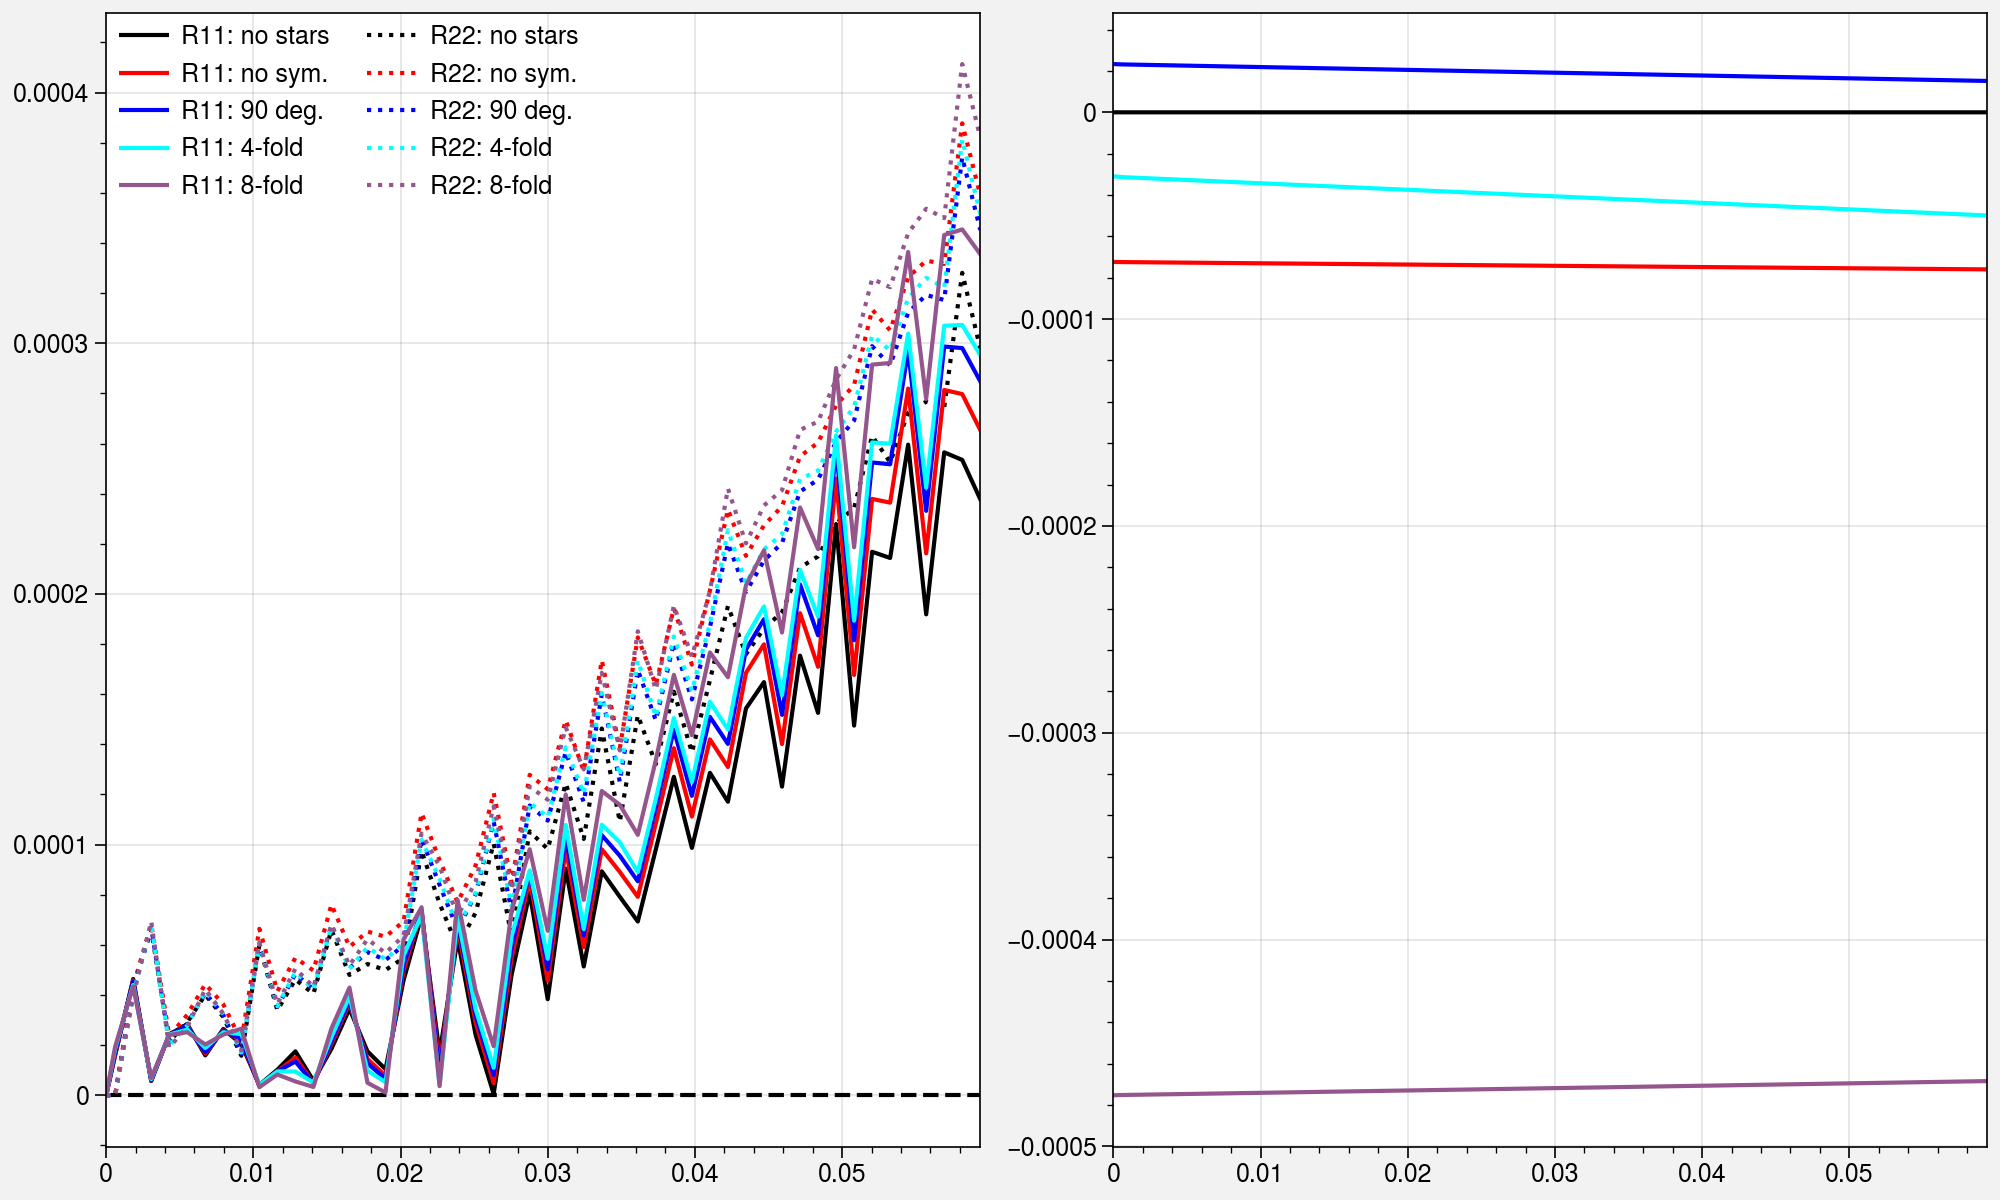

In [28]:
fig, axs = pplt.subplots(figsize=(10, 6), ncols=2, sharey=0)
lgs = []

for tail, color in zip(
    ["no stars", "no sym.", "90 deg.", "4-fold", "8-fold"],
    ["k", "red", "blue", "cyan", "purple"],
#     ["no sym.", "8-fold"],
#     ["red", "purple"],
):
    for head, sty in zip(["R11: ", "R22: "], ["solid", "dotted"]):
        key = head + tail
        data = datas[key]
        lgs.append(axs[0].plot(
            data["shear"], np.abs(data["R"]/data["R"][0]-1), 
            label=key, color=color, linestyle=sty,
        ))

# axs[0].hlines(0.001, data["shear"][0], data["shear"][-1], linestyle='dashed', color='k')
axs[0].hlines(0.00, data["shear"][0], data["shear"][-1], linestyle='dashed', color='k')
# axs[0].hlines(-0.001, data["shear"][0], data["shear"][-1], linestyle='dashed', color='k')
# axs[0].set_ylim(-1e-4, 1.5e-3)
axs[0].set_xlim(data["shear"][0], data["shear"][-1])
axs[0].legend(lgs, loc='ul', ncols=2, frameon=False, framealpha=0)


for tail, color in zip(
    ["no stars", "no sym.", "90 deg.", "4-fold", "8-fold"],
    ["k", "red", "blue", "cyan", "purple"],
):
    for head, sty in zip(["R11: "], ["solid"]):
        key = head + tail
        data = datas[key]
        lgs.append(axs[1].plot(
            data["shear"], data["e2"], 
            label=key, color=color, linestyle=sty,
        ))

axs[1].set_xlim(data["shear"][0], data["shear"][-1])

In [ ]:
def _do_plots(axs, seed, sym_nfold, interp, **kwargs):
    hdls = []
    for pval in pixvals:
        if pval is None:
            sp, R, mf = meas_R_mask(None, rotate, symdelta=symdelta)
            hdls.append(axs.plot(sp, R/R[0], label='no masking'))
        else:
            sp, R, mf = meas_R_mask(pval, rotate, symdelta=symdelta)
            hdls.append(axs.plot(
                    sp, R/R[0], 
                    label='%d pix - rotated=%s - symdelta=%d - interp=%d - mfrac=%0.3f ' % (
                        pval, rotate, symdelta, interp, mf
                    ), 
                    **kwargs
                )
            )

    return hdls

fig, axs = pplt.subplots(figsize=(8, 6))

hdls = _do_plots(axs, False, 0, [None, 2, 4, 8], False)
hdls.extend(_do_plots(axs, True, 0, [2], False, linestyle='dashed', color='purple'))
hdls.extend(_do_plots(axs, True, 1, [2], False, linestyle='dotted', color='purple'))
hdls.extend(_do_plots(axs, True, 0, [2], True, linestyle='dashed', color='cyan'))

axs.legend(hdls, loc='ul', ncols=1, frameon=False, framealpha=0)
axs.format(xlabel='true shear')
axs.format(ylabel='response(shear) / response(shear=0)')
axs.grid(False)